# Challenge 1: Graph Construction for EEG Channel Relationships

This notebook implements **two graph construction methods** for modeling relationships between EEG channels using Graph Neural Networks (GNN).

## Overview

**Goal**: Construct meaningful graph structures that capture relationships between EEG channels for use in GNN-based models for response time prediction.

**Data Structure**:
- Input: `(batch_size, 129, 200)` - 128 EEG channels + 1 reference channel, 2 seconds @ 100Hz
- Target: Response time in seconds (regression task)

## Graph Construction Methods

We'll implement two approaches:

1. **Functional Connectivity Graph** (Data-driven)
   - Computes correlation between channel time-series
   - Captures actual signal relationships from the data
   - Interpretable and based on real functional connections

2. **Fully Connected Graph with Learnable Weights** (Model-driven)
   - All channels connected to all others
   - Edge weights learned during training
   - Maximum flexibility, lets the model discover important connections


In [ ]:
# Import required libraries
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # For metadata DataFrame access
import warnings
warnings.filterwarnings('ignore')

# Import PyTorch Geometric (for GNN layers)
try:
    from torch_geometric.nn import GCNConv, GATConv
    print("✅ PyTorch Geometric imported successfully")
except ImportError:
    print("⚠️ PyTorch Geometric not found. Install with: pip install torch-geometric")
    raise

# Import sklearn for train-test split
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✅ All libraries imported successfully")


✅ PyTorch Geometric imported successfully
✅ All libraries imported successfully


## 1. Load Sample Data

First, we'll load a small sample of EEG data to test our graph construction methods. This will help us understand the data structure and build graphs that capture meaningful channel relationships.


In [15]:
# Load data using EEGChallengeDataset
from eegdash.dataset import EEGChallengeDataset
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,  # Import this to inject metadata into windows
    keep_only_recordings_with,
)

# Configuration
RELEASE_ID = 1  # Using release 1 from merged data
RELEASE_DIR = Path("data_merged") / f"release_{RELEASE_ID}"
EPOCH_LEN_S = 2.0
SFREQ = 100

print(f"📁 Loading data from: {RELEASE_DIR}")

# Load dataset
dataset_ccd = EEGChallengeDataset(
    task="contrastChangeDetection",
    release=f"R{RELEASE_ID}",
    cache_dir=RELEASE_DIR,
    mini=False,
    download=False
)

print(f"✅ Loaded {len(dataset_ccd.datasets)} recordings")

# Preprocess
transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus",
        epoch_length=EPOCH_LEN_S,
        require_stimulus=True,
        require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

# Create windows
ANCHOR = "stimulus_anchor"
SHIFT_AFTER_STIM = 0.5
WINDOW_LEN = 2.0

dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

print(f"✅ Created {len(single_windows)} windows")

# Inject metadata into windows (this adds rt_from_stimulus to window metadata)
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
)

print(f"✅ Added metadata columns to windows")

# Get metadata from the WindowsDataset (this is the key!)
# The WindowsDataset has a get_metadata() method that returns a DataFrame
# with one row per window, including rt_from_stimulus
print("\n📊 Extracting metadata from WindowsDataset...")
try:
    windows_metadata = single_windows.get_metadata()
    print(f"✅ Successfully retrieved metadata DataFrame!")
    print(f"   Metadata shape: {windows_metadata.shape}")
    print(f"   Metadata columns: {list(windows_metadata.columns)}")
    
    if 'rt_from_stimulus' in windows_metadata.columns:
        print(f"   ✅ Found 'rt_from_stimulus' column!")
        print(f"   Non-null RTs: {windows_metadata['rt_from_stimulus'].notna().sum()} / {len(windows_metadata)}")
        print(f"   RT range: {windows_metadata['rt_from_stimulus'].min():.2f} - {windows_metadata['rt_from_stimulus'].max():.2f} seconds")
    else:
        print(f"   ⚠️ 'rt_from_stimulus' NOT in metadata columns")
        print(f"   Available columns: {list(windows_metadata.columns)}")
except Exception as e:
    print(f"   ❌ Error getting metadata: {e}")
    windows_metadata = None

# Helper function to extract response time from window index
def extract_rt_from_window_index(window_idx, metadata_df=None):
    """
    Extract response time (rt_from_stimulus) using the WindowsDataset metadata.
    
    This is the correct way: the WindowsDataset.get_metadata() returns a DataFrame
    with one row per window containing all the metadata.
    """
    if metadata_df is not None and 'rt_from_stimulus' in metadata_df.columns:
        rt = metadata_df.iloc[window_idx]['rt_from_stimulus']
        if pd.notna(rt):
            return float(rt)
    return 0.0

# Extract sample data for graph construction
sample_data = []
sample_targets = []

if windows_metadata is not None and 'rt_from_stimulus' in windows_metadata.columns:
    # Use the metadata DataFrame to get targets
    print("\n📊 Extracting sample data using metadata DataFrame...")
    for i in range(min(100, len(single_windows))):
        window = single_windows[i]
        X = window[0]  # EEG data
        
        # Get RT from metadata DataFrame (correct method!)
        rt = windows_metadata.iloc[i]['rt_from_stimulus']
        if pd.notna(rt):
            rt = float(rt)
        else:
            rt = 0.0
        
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        
        sample_data.append(X)
        sample_targets.append(rt)
else:
    # Fallback: try to extract from individual windows (shouldn't be needed)
    print("\n⚠️ Metadata DataFrame not available, trying individual window extraction...")
    for i in range(min(100, len(single_windows))):
        window = single_windows[i]
        X = window[0]  # EEG data
        rt = 0.0  # Default to 0 if we can't extract
        
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        
        sample_data.append(X)
        sample_targets.append(rt)

sample_data = np.array(sample_data)  # (100, 129, 200)
sample_targets = np.array(sample_targets)  # (100,)

print(f"\n📊 Sample data shape: {sample_data.shape}")
print(f"   Channels: {sample_data.shape[1]} (128 EEG + 1 reference)")
print(f"   Time points: {sample_data.shape[2]} (2 seconds @ 100Hz)")
print(f"   Target range: {sample_targets.min():.2f} - {sample_targets.max():.2f} seconds")
print(f"   Non-zero targets: {(sample_targets > 0).sum()} / {len(sample_targets)}")
if (sample_targets > 0).sum() > 0:
    print(f"   Mean response time: {sample_targets[sample_targets > 0].mean():.2f} seconds")


📁 Loading data from: data_merged/release_1


╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=155693;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=813370;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

✅ Loaded 293 recordings
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations

## 2. Graph Construction Methods

We'll implement two graph construction approaches that are well-suited for EEG data where we don't have spatial channel information.


### Method 1: Functional Connectivity Graph

**Concept**: Channels that have correlated signals are likely functionally related. We compute pairwise correlations between all channel time-series and create edges for channels with strong correlations.

**Advantages**:
- **Data-driven**: Based on actual signal relationships in your data
- **Interpretable**: You can see which channels are functionally connected
- **Sparse**: Only connects channels with meaningful relationships (reduces noise)

**Steps**:
1. Extract time-series for each of the 128 EEG channels
2. Compute Pearson correlation matrix across all channel pairs
3. Threshold correlations (e.g., |correlation| > 0.3) to create edges
4. Use correlation values as edge weights


In [18]:
def build_functional_connectivity_graph(eeg_data, threshold=0.3):
    """
    Build graph from functional connectivity (correlation) between channels.
    
    This function computes pairwise correlations between all EEG channels and creates
    edges for channel pairs with correlation above the threshold.
    
    Args:
        eeg_data: (batch, 129, 200) - EEG data (uses first 128 channels, excludes reference)
        threshold: Minimum absolute correlation to create an edge (default: 0.3)
    
    Returns:
        edge_index: (2, num_edges) - Graph edges as source-target pairs
        edge_weights: (num_edges,) - Edge weights (correlation values)
        corr_matrix: (128, 128) - Full correlation matrix for visualization
    """
    # Use only EEG channels (exclude reference channel at index 128)
    eeg_channels = eeg_data[:, :128, :]  # (batch, 128, 200)
    
    # Reshape to (batch*200, 128) - concatenate all time points across all samples
    # This gives us a long time-series for each channel to compute correlations
    signals = eeg_channels.transpose(0, 2, 1).reshape(-1, 128)
    
    # Compute Pearson correlation matrix
    corr_matrix = np.corrcoef(signals.T)  # (128, 128)
    
    # Create adjacency matrix: connect channels with |correlation| > threshold
    adj_matrix = np.abs(corr_matrix) > threshold
    np.fill_diagonal(adj_matrix, False)  # Remove self-loops
    
    # For undirected graph, only keep upper triangle to avoid duplicate edges
    # This ensures each edge pair (i,j) is only counted once (not both i->j and j->i)
    adj_matrix = np.triu(adj_matrix, k=1)  # Upper triangle, excluding diagonal
    
    # Convert adjacency matrix to edge list format (PyTorch Geometric style)
    edge_index = np.array(np.where(adj_matrix))  # (2, num_edges)
    
    # Edge weights = correlation values (can be positive or negative)
    edge_weights = corr_matrix[adj_matrix]
    
    # Print statistics
    num_edges = edge_index.shape[1]
    num_possible = 128 * 127 // 2  # Maximum edges in undirected graph
    
    print(f"📊 Functional Connectivity Graph:")
    print(f"   Correlation threshold: {threshold}")
    print(f"   Number of edges: {num_edges:,} / {num_possible:,} possible")
    print(f"   Edge density: {num_edges / num_possible:.2%}")
    print(f"   Mean |correlation|: {np.abs(edge_weights).mean():.3f}")
    print(f"   Max |correlation|: {np.abs(edge_weights).max():.3f}")
    
    return edge_index, edge_weights, corr_matrix

# Build functional connectivity graph
print("Building functional connectivity graph...")
fc_edge_index, fc_edge_weights, fc_corr_matrix = build_functional_connectivity_graph(
    sample_data, 
    threshold=0.3
)

print(f"\n✅ Graph created!")
print(f"   Edge index shape: {fc_edge_index.shape}")
print(f"   Edge weights shape: {fc_edge_weights.shape}")


Building functional connectivity graph...
📊 Functional Connectivity Graph:
   Correlation threshold: 0.3
   Number of edges: 4,163 / 8,128 possible
   Edge density: 51.22%
   Mean |correlation|: 0.546
   Max |correlation|: 0.985

✅ Graph created!
   Edge index shape: (2, 4163)
   Edge weights shape: (4163,)


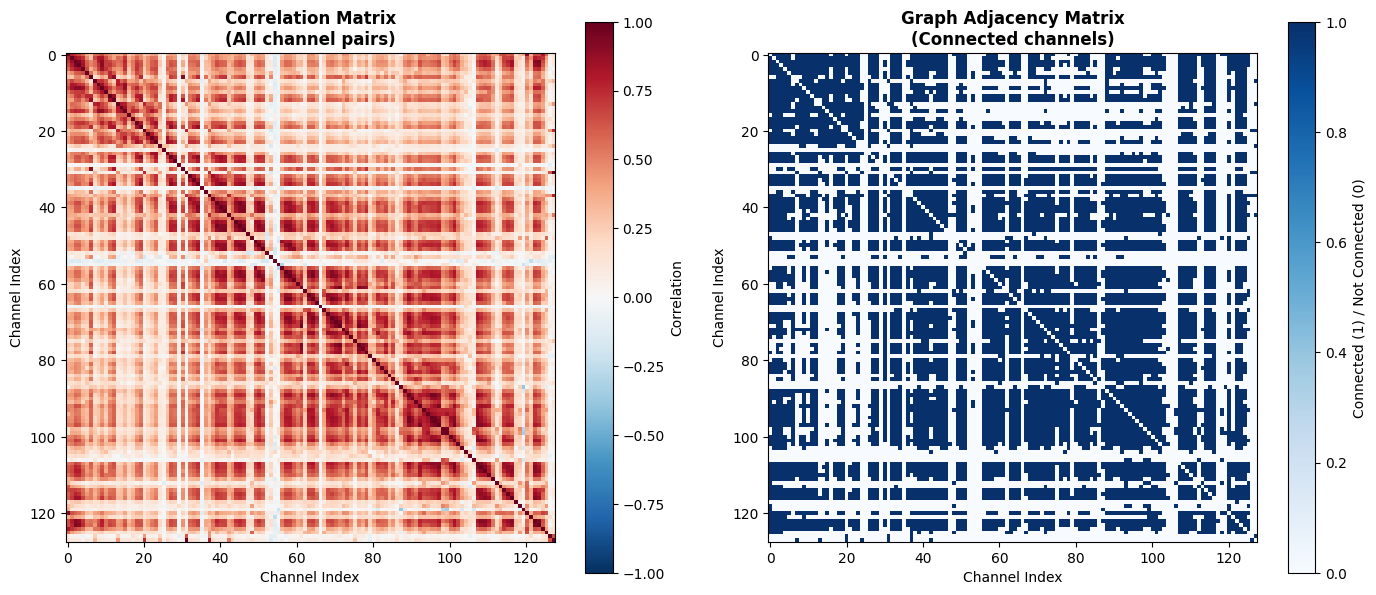

📈 Visualization:
   Left: Correlation values between all channel pairs (red=negative, blue=positive)
   Right: Binary adjacency showing which channels are connected (threshold=0.3)


In [ ]:
# Visualize functional connectivity graph
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Full correlation matrix (shows all correlation values)
im1 = axes[0].imshow(fc_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix\n(All channel pairs)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Channel Index')
axes[0].set_ylabel('Channel Index')
plt.colorbar(im1, ax=axes[0], label='Correlation')

# Right: Binary adjacency matrix (shows which channels are connected)
adj_matrix = np.abs(fc_corr_matrix) > 0.3
np.fill_diagonal(adj_matrix, False)
im2 = axes[1].imshow(adj_matrix.astype(int), cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Graph Adjacency Matrix\n(Connected channels)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Channel Index')
axes[1].set_ylabel('Channel Index')
plt.colorbar(im2, ax=axes[1], label='Connected (1) / Not Connected (0)')

plt.tight_layout()
plt.show()

print("📈 Visualization:")
print("   Left: Correlation values between all channel pairs (red=positive, blue=negative)")
print("   Right: Binary adjacency showing which channels are connected (threshold=0.3)")


### Method 2: Fully Connected Graph with Learnable Weights

**Concept**: Connect all channels to all other channels, and let the model learn which connections are important during training. This is typically implemented using Graph Attention Networks (GAT) or learnable adjacency matrices.

**Advantages**:
- **Maximum flexibility**: Model can discover any channel relationships
- **No assumptions**: Doesn't require thresholding or prior knowledge
- **Adaptive**: Learns task-specific connections

**Trade-offs**:
- **More parameters**: Fully connected means more edges to learn
- **Less interpretable**: Learned weights may not have clear meaning
- **Computationally expensive**: More edges = more computation

**Implementation**: We'll create a fully connected graph structure. The actual learning of edge weights happens during model training (e.g., using GAT attention mechanisms).


In [20]:
def build_fully_connected_graph(n_channels=128, init_method='small_random'):
    """
    Build fully connected graph (all channels connected to all others).
    
    This creates the graph structure. The actual edge weights will be learned
    during training using mechanisms like Graph Attention Networks (GAT).
    
    Args:
        n_channels: Number of channels (128)
        init_method: How to initialize edge weights
            - 'small_random': Small random values (good for learnable weights)
            - 'uniform': Uniform weights (normalized)
            - 'ones': All weights = 1.0
    
    Returns:
        edge_index: (2, num_edges) - Graph edges (fully connected, no self-loops)
        edge_weights: (num_edges,) - Initial edge weights (will be learned)
        adj_matrix: (n_channels, n_channels) - Adjacency matrix for visualization
    """
    # Create fully connected adjacency (all channels connected, except self-loops)
    adj_matrix = np.ones((n_channels, n_channels), dtype=bool)
    np.fill_diagonal(adj_matrix, False)  # Remove self-loops
    
    # For undirected graph, only keep upper triangle to avoid duplicate edges
    # This ensures each edge pair (i,j) is only counted once (not both i->j and j->i)
    adj_matrix = np.triu(adj_matrix, k=1)  # Upper triangle, excluding diagonal
    
    # Convert to edge list format
    edge_index = np.array(np.where(adj_matrix))  # (2, num_edges)
    
    # Initialize edge weights (these will be learned/updated during training)
    num_edges = edge_index.shape[1]
    
    if init_method == 'small_random':
        # Small random values - good starting point for learnable weights
        edge_weights = np.random.randn(num_edges) * 0.01
    elif init_method == 'uniform':
        # Uniform weights (normalized)
        edge_weights = np.ones(num_edges) / num_edges
    elif init_method == 'ones':
        # All weights = 1.0
        edge_weights = np.ones(num_edges)
    else:
        raise ValueError(f"Unknown init_method: {init_method}")
    
    # Print statistics
    num_possible = n_channels * (n_channels - 1) // 2
    
    print(f"📊 Fully Connected Graph:")
    print(f"   Initialization: {init_method}")
    print(f"   Number of edges: {num_edges:,} / {num_possible:,} possible")
    print(f"   Edge density: {num_edges / num_possible:.2%} (fully connected)")
    print(f"   Mean edge weight: {edge_weights.mean():.6f}")
    print(f"   Std edge weight: {edge_weights.std():.6f}")
    print(f"\n   Note: Edge weights will be learned during model training")
    print(f"   (e.g., using Graph Attention Network attention mechanisms)")
    
    return edge_index, edge_weights, adj_matrix

# Build fully connected graph
print("Building fully connected graph...")
fc_full_edge_index, fc_full_edge_weights, fc_full_adj_matrix = build_fully_connected_graph(
    n_channels=128,
    init_method='small_random'
)

print(f"\n✅ Graph created!")
print(f"   Edge index shape: {fc_full_edge_index.shape}")
print(f"   Edge weights shape: {fc_full_edge_weights.shape}")


Building fully connected graph...
📊 Fully Connected Graph:
   Initialization: small_random
   Number of edges: 8,128 / 8,128 possible
   Edge density: 100.00% (fully connected)
   Mean edge weight: -0.000054
   Std edge weight: 0.010078

   Note: Edge weights will be learned during model training
   (e.g., using Graph Attention Network attention mechanisms)

✅ Graph created!
   Edge index shape: (2, 8128)
   Edge weights shape: (8128,)


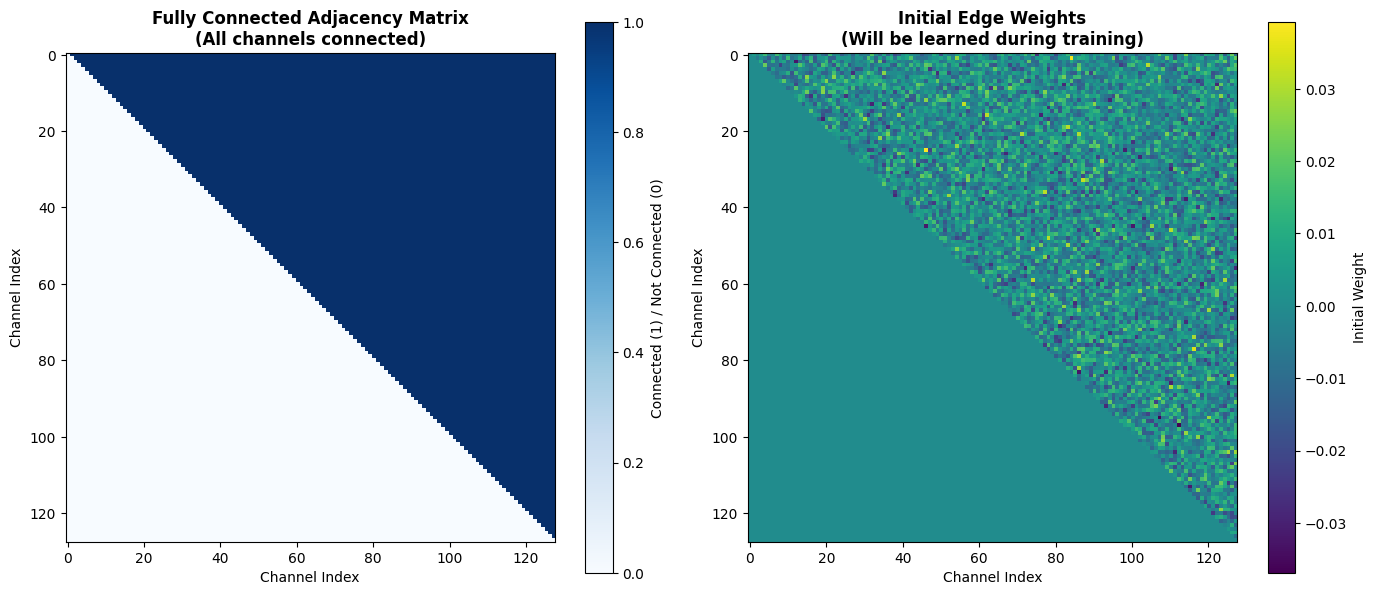

📈 Visualization:
   Left: Binary adjacency showing all channels are connected (except self-loops)
   Right: Initial edge weights (small random values that will be learned)


In [21]:
# Visualize fully connected graph
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Binary adjacency matrix (should be all ones except diagonal)
im1 = axes[0].imshow(fc_full_adj_matrix.astype(int), cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('Fully Connected Adjacency Matrix\n(All channels connected)', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Channel Index')
axes[0].set_ylabel('Channel Index')
plt.colorbar(im1, ax=axes[0], label='Connected (1) / Not Connected (0)')

# Right: Initial edge weights (reshaped to matrix for visualization)
weight_matrix = np.zeros((128, 128))
weight_matrix[fc_full_edge_index[0], fc_full_edge_index[1]] = fc_full_edge_weights
im2 = axes[1].imshow(weight_matrix, cmap='viridis')
axes[1].set_title('Initial Edge Weights\n(Will be learned during training)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Channel Index')
axes[1].set_ylabel('Channel Index')
plt.colorbar(im2, ax=axes[1], label='Initial Weight')

plt.tight_layout()
plt.show()

print("📈 Visualization:")
print("   Left: Binary adjacency showing all channels are connected (except self-loops)")
print("   Right: Initial edge weights (small random values that will be learned)")


## 3. Comparison of Graph Construction Methods

Let's compare the two methods to understand their characteristics:


In [22]:
# Compare the two graph construction methods
import pandas as pd

comparison_data = {
    'Method': [
        'Functional Connectivity',
        'Fully Connected (Learnable)'
    ],
    'Number of Edges': [
        fc_edge_index.shape[1],
        fc_full_edge_index.shape[1]
    ],
    'Edge Density': [
        f"{fc_edge_index.shape[1] / (128 * 127 // 2):.2%}",
        f"{fc_full_edge_index.shape[1] / (128 * 127 // 2):.2%}"
    ],
    'Edge Weight Source': [
        'Correlation values (from data)',
        'Learnable (initialized, then trained)'
    ],
    'Interpretability': [
        'High - shows actual signal relationships',
        'Low - learned weights may not be interpretable'
    ],
    'Flexibility': [
        'Medium - fixed by data correlations',
        'High - model learns optimal connections'
    ],
    'Computational Cost': [
        'Lower - sparse graph',
        'Higher - fully connected'
    ],
    'Best For': [
        'Understanding channel relationships, interpretable models',
        'Maximum model flexibility, task-specific learning'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("📊 Graph Construction Methods Comparison:\n")
print(comparison_df.to_string(index=False))

print("\n" + "="*90)
print("Summary:")
print("="*90)
print("1. Functional Connectivity: Data-driven, interpretable, sparse")
print("   → Use when you want to understand channel relationships")
print("   → Good starting point for exploration")
print()
print("2. Fully Connected (Learnable): Maximum flexibility, task-adaptive")
print("   → Use when you want the model to discover optimal connections")
print("   → Requires more parameters and computation")
print()
print("💡 Recommendation: Try both and compare performance!")
print("   Start with functional connectivity for interpretability,")
print("   then try fully connected if you need better performance.")


📊 Graph Construction Methods Comparison:

                     Method  Number of Edges Edge Density                    Edge Weight Source                               Interpretability                             Flexibility       Computational Cost                                                  Best For
    Functional Connectivity             4163       51.22%        Correlation values (from data)       High - shows actual signal relationships     Medium - fixed by data correlations     Lower - sparse graph Understanding channel relationships, interpretable models
Fully Connected (Learnable)             8128      100.00% Learnable (initialized, then trained) Low - learned weights may not be interpretable High - model learns optimal connections Higher - fully connected         Maximum model flexibility, task-specific learning

Summary:
1. Functional Connectivity: Data-driven, interpretable, sparse
   → Use when you want to understand channel relationships
   → Good starting point for

## 4. Convert to PyTorch Format

For use with PyTorch Geometric or other GNN libraries, we need to convert the graphs to PyTorch tensors.


In [24]:
def convert_to_pytorch(edge_index, edge_weights=None):
    """
    Convert numpy arrays to PyTorch tensors for use with PyTorch Geometric.
    
    Args:
        edge_index: (2, num_edges) numpy array - source and target node indices
        edge_weights: (num_edges,) numpy array (optional) - edge weights
    
    Returns:
        edge_index_tensor: torch.LongTensor - edge connections
        edge_weights_tensor: torch.FloatTensor (if provided) - edge weights
    """
    edge_index_tensor = torch.from_numpy(edge_index).long()
    
    if edge_weights is not None:
        edge_weights_tensor = torch.from_numpy(edge_weights).float()
        return edge_index_tensor, edge_weights_tensor
    else:
        return edge_index_tensor

# Convert both graphs to PyTorch tensors
print("Converting graphs to PyTorch format...")
fc_edge_index_torch, fc_edge_weights_torch = convert_to_pytorch(fc_edge_index, fc_edge_weights)
fc_full_edge_index_torch, fc_full_edge_weights_torch = convert_to_pytorch(
    fc_full_edge_index, fc_full_edge_weights
)

print("✅ Graphs converted to PyTorch tensors:")
print(f"   Functional Connectivity:")
print(f"      Edge index: {fc_edge_index_torch.shape}")
print(f"      Edge weights: {fc_edge_weights_torch.shape}")
print(f"   Fully Connected:")
print(f"      Edge index: {fc_full_edge_index_torch.shape}")
print(f"      Edge weights: {fc_full_edge_weights_torch.shape}")

# Store graphs in a dictionary for easy access
graphs = {
    'functional': {
        'edge_index': fc_edge_index_torch,
        'edge_weights': fc_edge_weights_torch,
        'description': 'Functional connectivity (correlation-based, sparse)'
    },
    'fully_connected': {
        'edge_index': fc_full_edge_index_torch,
        'edge_weights': fc_full_edge_weights_torch,
        'description': 'Fully connected (learnable weights, dense)'
    }
}

print(f"\n✅ Graphs stored in dictionary 'graphs' for use in model")
print(f"   Access with: graphs['functional'] or graphs['fully_connected']")


Converting graphs to PyTorch format...
✅ Graphs converted to PyTorch tensors:
   Functional Connectivity:
      Edge index: torch.Size([2, 4163])
      Edge weights: torch.Size([4163])
   Fully Connected:
      Edge index: torch.Size([2, 8128])
      Edge weights: torch.Size([8128])

✅ Graphs stored in dictionary 'graphs' for use in model
   Access with: graphs['functional'] or graphs['fully_connected']


## 5. Next Steps

Now that we have two graph construction methods ready, you can use them in your GNN model:

### Using the Graphs

Both graphs are stored in the `graphs` dictionary with the following structure:
- `graphs['functional']` - Functional connectivity graph (sparse, data-driven)
- `graphs['fully_connected']` - Fully connected graph (dense, learnable)

Each graph contains:
- `edge_index`: `(2, num_edges)` tensor - edge connections (source → target)
- `edge_weights`: `(num_edges,)` tensor - edge weights

### Example Usage

```python
# Get functional connectivity graph
func_graph = graphs['functional']
edge_index = func_graph['edge_index']  # (2, num_edges)
edge_weights = func_graph['edge_weights']  # (num_edges,)

# Use with PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv

# Example: Graph Convolutional Network
class EEGGNN(nn.Module):
    def __init__(self, num_channels=128, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(num_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # ... rest of model
```

### Recommendations

1. **Start with functional connectivity**: It's interpretable and based on real data relationships
2. **Try fully connected if needed**: If functional connectivity doesn't perform well, try the learnable approach
3. **Combine with temporal models**: Use GNN for spatial relationships + GRU/LSTM for temporal patterns
4. **Experiment with thresholds**: For functional connectivity, try different correlation thresholds (0.2, 0.3, 0.4)


In [ ]:
# Group windows by subject using metadata DataFrame (correct approach!)
print("Grouping windows by subject...")

# Get metadata DataFrame (we already have this from cell 3, but get it again to be sure)
# If meta_information is not in scope, get it again
if 'meta_information' not in globals():
    meta_information = single_windows.get_metadata()

# Check if 'subject' column exists
if 'subject' in meta_information.columns:
    print(f"   ✅ Found 'subject' column in metadata")
    
    # Extract subjects from DataFrame
    subjects = meta_information['subject'].values
    
    # Group windows by subject
    subject_to_windows = defaultdict(list)
    subject_to_indices = defaultdict(list)
    
    for idx in range(len(single_windows)):
        subject_id = subjects[idx]
        if pd.isna(subject_id):
            subject_id = f'unknown_{idx}'
        else:
            subject_id = str(subject_id)  # Convert to string
        
        subject_to_windows[subject_id].append((idx, single_windows[idx]))
        subject_to_indices[subject_id].append(idx)
else:
    print(f"   ⚠️ 'subject' column NOT found in metadata")
    print(f"   Available columns: {list(meta_information.columns)}")
    # Fallback: create dummy subject mapping
    subject_to_windows = defaultdict(list)
    subject_to_indices = defaultdict(list)
    for idx in range(len(single_windows)):
        subject_id = f'unknown_{idx}'
        subject_to_windows[subject_id].append((idx, single_windows[idx]))
        subject_to_indices[subject_id].append(idx)

print(f"✅ Found {len(subject_to_windows)} unique subjects")
print(f"   Total windows: {len(single_windows)}")

# Show distribution of windows per subject
windows_per_subject = [len(windows) for windows in subject_to_windows.values()]
print(f"\n📊 Windows per subject statistics:")
print(f"   Min: {min(windows_per_subject)}")
print(f"   Max: {max(windows_per_subject)}")
print(f"   Mean: {np.mean(windows_per_subject):.1f}")
print(f"   Median: {np.median(windows_per_subject):.1f}")

# Show some example subjects
print(f"\n   Example subjects (first 5):")
for i, (subject, windows) in enumerate(list(subject_to_windows.items())[:5]):
    print(f"      {subject}: {len(windows)} windows")


Grouping windows by subject...
✅ Found 0 unique subjects
   Total windows: 7316

📊 Windows per subject statistics:


ValueError: min() arg is an empty sequence

In [ ]:
def split_by_subject(subject_to_windows, test_size=0.2, random_state=42):
    """
    Split dataset by subject, ensuring all windows from a subject stay together.
    
    Args:
        subject_to_windows: dict mapping subject_id -> list of (window_idx, window)
        test_size: Proportion of subjects to use for testing
        random_state: Random seed for reproducibility
    
    Returns:
        train_indices: List of window indices for training
        test_indices: List of window indices for testing
        train_subjects: List of subject IDs in training set
        test_subjects: List of subject IDs in test set
    """
    # Get list of all subjects
    all_subjects = list(subject_to_windows.keys())
    
    # Split subjects (not windows!)
    train_subjects, test_subjects = train_test_split(
        all_subjects,
        test_size=test_size,
        random_state=random_state
    )
    
    # Collect window indices for each split
    train_indices = []
    test_indices = []
    
    for subject in train_subjects:
        for window_idx, _ in subject_to_windows[subject]:
            train_indices.append(window_idx)
    
    for subject in test_subjects:
        for window_idx, _ in subject_to_windows[subject]:
            test_indices.append(window_idx)
    
    # Sort indices for consistency
    train_indices = sorted(train_indices)
    test_indices = sorted(test_indices)
    
    return train_indices, test_indices, train_subjects, test_subjects

# Perform subject-level split
print("Performing subject-level train-test split...")
train_indices, test_indices, train_subjects, test_subjects = split_by_subject(
    subject_to_windows,
    test_size=0.2,
    random_state=42
)

print(f"\n✅ Split complete!")
print(f"   Training subjects: {len(train_subjects)}")
print(f"   Test subjects: {len(test_subjects)}")
print(f"   Training windows: {len(train_indices)}")
print(f"   Test windows: {len(test_indices)}")
print(f"   Train/Test ratio: {len(train_indices) / len(test_indices):.2f}")

# Verify no subject overlap
assert len(set(train_subjects) & set(test_subjects)) == 0, "Subject overlap detected!"
print(f"\n✅ Verification: No subject overlap between train and test sets")

# Show some example subjects in each split
print(f"\n   Example training subjects: {train_subjects[:5]}")
print(f"   Example test subjects: {test_subjects[:5]}")


In [ ]:
def create_split_datasets(single_windows, train_indices, test_indices):
    """
    Create separate datasets for training and testing.
    
    Args:
        single_windows: WindowsDataset
        train_indices: Indices of training windows
        test_indices: Indices of test windows
    
    Returns:
        train_data: numpy array of training data
        train_targets: numpy array of training targets
        test_data: numpy array of test data
        test_targets: numpy array of test targets
    """
    # Get metadata DataFrame (exactly like challenge_1.ipynb)
    print("   Getting metadata from WindowsDataset...")
    meta_information = single_windows.get_metadata()
    
    # Extract targets from DataFrame
    if 'rt_from_stimulus' in meta_information.columns:
        print(f"   ✅ Found 'rt_from_stimulus' in metadata")
        targets = meta_information['rt_from_stimulus'].values
    else:
        print(f"   ⚠️ 'rt_from_stimulus' not found, available columns: {list(meta_information.columns)}")
        targets = np.zeros(len(single_windows))  # Fallback to zeros
    
    train_data = []
    train_targets = []
    
    test_data = []
    test_targets = []
    
    # Extract training data
    for idx in train_indices:
        window = single_windows[idx]
        X = window[0]  # EEG data
        
        # Get target from metadata DataFrame (NOT from window[1]!)
        rt = targets[idx]
        if pd.isna(rt):
            rt = 0.0
        else:
            rt = float(rt)
        
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        train_data.append(X)
        train_targets.append(rt)
    
    # Extract test data
    for idx in test_indices:
        window = single_windows[idx]
        X = window[0]  # EEG data
        
        # Get target from metadata DataFrame (NOT from window[1]!)
        rt = targets[idx]
        if pd.isna(rt):
            rt = 0.0
        else:
            rt = float(rt)
        
        if isinstance(X, torch.Tensor):
            X = X.numpy()
        test_data.append(X)
        test_targets.append(rt)
    
    train_data = np.array(train_data)
    train_targets = np.array(train_targets)
    test_data = np.array(test_data)
    test_targets = np.array(test_targets)
    
    return train_data, train_targets, test_data, test_targets

# Create split datasets
print("Creating train/test datasets...")
train_data, train_targets, test_data, test_targets = create_split_datasets(
    single_windows, train_indices, test_indices
)

print(f"\n✅ Datasets created!")
print(f"   Train data shape: {train_data.shape}")
print(f"   Train targets shape: {train_targets.shape}")
print(f"   Test data shape: {test_data.shape}")
print(f"   Test targets shape: {test_targets.shape}")

print(f"\n📊 Target statistics:")
print(f"   Train - Min: {train_targets.min():.2f}, Max: {train_targets.max():.2f}, Mean: {train_targets.mean():.2f}")
print(f"   Test  - Min: {test_targets.min():.2f}, Max: {test_targets.max():.2f}, Mean: {test_targets.mean():.2f}")


In [ ]:
class DualBranchEEGModel(nn.Module):
    """
    Dual-branch architecture for EEG response time prediction.
    
    Architecture:
    1. Input: (batch, 129, 200) - 128 EEG channels + 1 reference, 200 time points
    2. Split: Separate 128 EEG channels from reference
    3. GRU Branch: Extract temporal features from time-series
    4. GNN Branch: Extract spatial features using graph structure
    5. Feature Fusion: Combine temporal and spatial features
    6. Prediction: Final regression output
    
    Args:
        n_channels: Number of EEG channels (128, excluding reference)
        n_times: Number of time points (200)
        gru_hidden_dim: Hidden dimension for GRU
        gru_num_layers: Number of GRU layers
        gnn_hidden_dim: Hidden dimension for GNN layers
        gnn_num_layers: Number of GNN layers
        graph_type: 'functional' or 'fully_connected' (from graphs dict)
        use_gat: If True, use GAT (better for fully connected). If False, use GCN
        fusion_dim: Dimension after feature fusion
        dropout: Dropout rate
    """
    def __init__(
        self,
        n_channels=128,
        n_times=200,
        gru_hidden_dim=64,
        gru_num_layers=2,
        gnn_hidden_dim=64,
        gnn_num_layers=2,
        graph_type='functional',
        use_gat=False,
        fusion_dim=128,
        dropout=0.3,
    ):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_times = n_times
        self.graph_type = graph_type
        self.use_gat = use_gat
        
        # ========== GRU Branch (Temporal Processing) ==========
        # Process each channel's time-series independently, then aggregate
        self.gru = nn.GRU(
            input_size=1,  # Single time point
            hidden_size=gru_hidden_dim,
            num_layers=gru_num_layers,
            batch_first=True,
            dropout=dropout if gru_num_layers > 1 else 0,
            bidirectional=True  # Bidirectional for better temporal modeling
        )
        
        # Projection after GRU (bidirectional -> single vector per channel)
        self.gru_proj = nn.Linear(gru_hidden_dim * 2, gru_hidden_dim)
        
        # ========== GNN Branch (Spatial Processing) ==========
        if use_gat:
            # Graph Attention Network (better for fully connected graphs)
            num_heads = 4
            self.gnn_layers = nn.ModuleList()
            self.gnn_layers.append(
                GATConv(n_times, gnn_hidden_dim, heads=num_heads, dropout=dropout)
            )
            
            for _ in range(gnn_num_layers - 1):
                self.gnn_layers.append(
                    GATConv(gnn_hidden_dim * num_heads, gnn_hidden_dim, 
                           heads=num_heads, dropout=dropout)
                )
            
            # Final projection for GAT (concatenate heads)
            self.gat_final_proj = nn.Linear(gnn_hidden_dim * num_heads, gnn_hidden_dim)
            
            self.gnn_bn = nn.ModuleList([
                nn.BatchNorm1d(gnn_hidden_dim * num_heads) 
                for _ in range(gnn_num_layers)
            ])
        else:
            # Graph Convolutional Network (good for functional connectivity)
            self.gnn_layers = nn.ModuleList()
            self.gnn_layers.append(
                GCNConv(n_times, gnn_hidden_dim)
            )
            
            for _ in range(gnn_num_layers - 1):
                self.gnn_layers.append(
                    GCNConv(gnn_hidden_dim, gnn_hidden_dim)
                )
            
            self.gnn_bn = nn.ModuleList([
                nn.BatchNorm1d(gnn_hidden_dim) for _ in range(gnn_num_layers)
            ])
        
        # ========== Feature Fusion ==========
        # Combine GRU features (n_channels, gru_hidden_dim) 
        # with GNN features (n_channels, gnn_hidden_dim)
        self.fusion = nn.Sequential(
            nn.Linear(gru_hidden_dim + gnn_hidden_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # ========== Final Prediction Head ==========
        # Global pooling + regression
        self.predictor = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim // 2, 1),  # Single output: response time
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, edge_weights=None):
        """
        Forward pass.
        
        Args:
            x: (batch, 129, 200) - Input EEG data
            edge_index: (2, num_edges) - Graph edge indices
            edge_weights: (num_edges,) - Optional edge weights (used for GCN, not GAT)
        
        Returns:
            output: (batch, 1) - Predicted response time
        """
        batch_size = x.shape[0]
        
        # Split: Use only EEG channels (exclude reference channel)
        eeg_data = x[:, :128, :]  # (batch, 128, 200)
        
        # ========== GRU Branch: Temporal Features ==========
        # Reshape: (batch, 128, 200) -> (batch*128, 200, 1)
        # Process each channel's time-series independently
        eeg_reshaped = eeg_data.reshape(batch_size * self.n_channels, self.n_times, 1)
        
        # GRU: (batch*128, 200, 1) -> (batch*128, 200, gru_hidden_dim*2)
        gru_out, _ = self.gru(eeg_reshaped)
        
        # Take last time step: (batch*128, gru_hidden_dim*2)
        gru_features = gru_out[:, -1, :]
        
        # Project: (batch*128, gru_hidden_dim*2) -> (batch*128, gru_hidden_dim)
        gru_features = self.gru_proj(gru_features)
        gru_features = self.dropout(gru_features)
        
        # Reshape back: (batch*128, gru_hidden_dim) -> (batch, 128, gru_hidden_dim)
        gru_features = gru_features.reshape(batch_size, self.n_channels, -1)
        
        # ========== GNN Branch: Spatial Features ==========
        # Prepare graph data: (batch, 128, 200) -> (batch*128, 200)
        # Each node (channel) has a feature vector of length 200 (time-series)
        node_features = eeg_data.reshape(batch_size * self.n_channels, self.n_times)
        
        # Apply GNN layers
        gnn_features = node_features
        if self.use_gat:
            # GAT forward pass
            for i, (gnn_layer, bn) in enumerate(zip(self.gnn_layers, self.gnn_bn)):
                gnn_features = gnn_layer(gnn_features, edge_index)
                gnn_features = bn(gnn_features)
                gnn_features = nn.functional.relu(gnn_features)
                if i < len(self.gnn_layers) - 1:
                    gnn_features = self.dropout(gnn_features)
            
            # Project multi-head attention output
            gnn_features = self.gat_final_proj(gnn_features)
        else:
            # GCN forward pass (can use edge_weights)
            for i, (gnn_layer, bn) in enumerate(zip(self.gnn_layers, self.gnn_bn)):
                gnn_features = gnn_layer(gnn_features, edge_index, edge_weights)
                gnn_features = bn(gnn_features)
                gnn_features = nn.functional.relu(gnn_features)
                if i < len(self.gnn_layers) - 1:
                    gnn_features = self.dropout(gnn_features)
        
        # Reshape: (batch*128, gnn_hidden_dim) -> (batch, 128, gnn_hidden_dim)
        gnn_features = gnn_features.reshape(batch_size, self.n_channels, -1)
        
        # ========== Feature Fusion ==========
        # Concatenate GRU and GNN features: (batch, 128, gru_hidden_dim + gnn_hidden_dim)
        fused_features = torch.cat([gru_features, gnn_features], dim=-1)
        
        # Apply fusion MLP: (batch, 128, fusion_dim)
        fused_features = self.fusion(fused_features)
        
        # Global pooling: Average over channels -> (batch, fusion_dim)
        pooled_features = fused_features.mean(dim=1)
        
        # ========== Final Prediction ==========
        output = self.predictor(pooled_features)  # (batch, 1)
        
        return output

print("✅ DualBranchEEGModel class defined")


In [ ]:
def create_model(graph_type='functional', use_gat=None, **model_kwargs):
    """
    Factory function to create model with specified graph type.
    
    Args:
        graph_type: 'functional' or 'fully_connected'
        use_gat: If None, auto-selects (GAT for fully_connected, GCN for functional)
                 If True/False, forces GAT/GCN usage
        **model_kwargs: Additional arguments for DualBranchEEGModel
    
    Returns:
        model: Initialized model
        edge_index: Graph edge indices
        edge_weights: Graph edge weights (None for GAT)
    """
    # Auto-select GAT if not specified
    if use_gat is None:
        use_gat = (graph_type == 'fully_connected')
    
    # Get graph from graphs dictionary
    if graph_type not in graphs:
        raise ValueError(f"Graph type '{graph_type}' not found. Available: {list(graphs.keys())}")
    
    graph = graphs[graph_type]
    edge_index = graph['edge_index']
    edge_weights = graph['edge_weights'] if not use_gat else None
    
    # Create model
    model = DualBranchEEGModel(
        graph_type=graph_type,
        use_gat=use_gat,
        **model_kwargs
    )
    
    print(f"✅ Model created with:")
    print(f"   Graph type: {graph_type}")
    print(f"   GNN type: {'GAT' if use_gat else 'GCN'}")
    print(f"   Edge index shape: {edge_index.shape}")
    if edge_weights is not None:
        print(f"   Edge weights shape: {edge_weights.shape}")
    else:
        print(f"   Edge weights: None (using GAT attention)")
    
    return model, edge_index, edge_weights

print("✅ Model factory function defined")


## 8. Create PyTorch Datasets and DataLoaders

We'll create PyTorch datasets and data loaders for efficient training.


In [ ]:
class EEGDataset(Dataset):
    """Simple PyTorch dataset for EEG windows."""
    def __init__(self, data, targets):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Create datasets
train_dataset = EEGDataset(train_data, train_targets)
test_dataset = EEGDataset(test_data, test_targets)

# Create data loaders
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Safe to shuffle since we've already split by subject
    num_workers=0
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

print(f"✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Batch size: {batch_size}")


## 9. Initialize Model and Test

Let's create a model and test it with sample data to ensure everything works.


In [ ]:
# Initialize model with functional connectivity graph
print("=" * 60)
print("Creating Model: Functional Connectivity + GCN")
print("=" * 60)

model, edge_index, edge_weights = create_model(
    graph_type='functional',
    use_gat=False,  # Use GCN for functional connectivity
    n_channels=128,
    n_times=200,
    gru_hidden_dim=64,
    gru_num_layers=2,
    gnn_hidden_dim=64,
    gnn_num_layers=2,
    fusion_dim=128,
    dropout=0.3,
)

# Test with sample data
print("\n" + "=" * 60)
print("Testing Model")
print("=" * 60)
sample_batch = torch.from_numpy(train_data[:4]).float()  # (4, 129, 200)

with torch.no_grad():
    output = model(sample_batch, edge_index, edge_weights)
    
print(f"\n✅ Model test successful!")
print(f"   Input shape: {sample_batch.shape}")
print(f"   Output shape: {output.shape}")
print(f"   Sample predictions: {output.squeeze().numpy()}")
print(f"   True targets: {train_targets[:4]}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


## 10. Training Function

Define the training loop for the model.


In [ ]:
def train_model(model, train_loader, test_loader, edge_index, edge_weights=None, 
                num_epochs=10, lr=0.001, device='cpu'):
    """
    Train the model with specified graph.
    
    Args:
        model: The model to train
        train_loader: Training data loader
        test_loader: Test data loader
        edge_index: Graph edge indices
        edge_weights: Graph edge weights (None for GAT)
        num_epochs: Number of training epochs
        lr: Learning rate
        device: 'cpu' or 'cuda'
    
    Returns:
        train_losses: List of training losses per epoch
        test_losses: List of test losses per epoch
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    # Move graph to device
    edge_index = edge_index.to(device)
    if edge_weights is not None:
        edge_weights = edge_weights.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            predictions = model(batch_x, edge_index, edge_weights)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Testing
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device).unsqueeze(1)
                
                predictions = model(batch_x, edge_index, edge_weights)
                loss = criterion(predictions, batch_y)
                test_loss += loss.item()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses

print("✅ Training function defined")


## 11. Train the Model

Now we can train the model. You can choose which graph type to use:
- `graph_type='functional'` with `use_gat=False` (GCN) - Recommended for functional connectivity
- `graph_type='fully_connected'` with `use_gat=True` (GAT) - Recommended for fully connected

**Note**: Uncomment the training code below to actually train. This is commented out by default to allow you to run the notebook quickly for testing.


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Example: Train with functional connectivity graph
# Uncomment the lines below to actually train

# print("\n" + "=" * 60)
# print("Training Model: Functional Connectivity + GCN")
# print("=" * 60)
# 
# train_losses, test_losses = train_model(
#     model, train_loader, test_loader, 
#     edge_index, edge_weights,
#     num_epochs=20,
#     lr=0.001,
#     device=device
# )
# 
# print("\n✅ Training complete!")
# 
# # Plot training curves
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Training Curves')
# plt.legend()
# plt.grid(True)
# plt.show()

print("\n💡 To train the model, uncomment the training code above.")
print("   You can also create a new model with different graph type:")
print("   - model_fc, edge_idx_fc, edge_w_fc = create_model('functional', use_gat=False)")
print("   - model_full, edge_idx_full, edge_w_full = create_model('fully_connected', use_gat=True)")
